# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from kaggle that contains information on 3 million used cars.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary. 

To exlore which factors influence the price of a car we will examine the available dataset to dermine which records are most useful for a prediction model. We will then create and test several different models to determine which is most useful. We will then examine which features that model uses to gain business insights. We will also discuss potential uses for the model itself.  

### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

In [1]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import SequentialFeatureSelector, RFE
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from scipy import stats
import category_encoders as ce
import numpy as np
import plotly.express as px
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=FutureWarning) 

In [2]:
cars=pd.read_csv('data/vehicles.csv')#import dataset and take first look at it
cars.head()

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
0,7222695916,prescott,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,az
1,7218891961,fayetteville,11900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ar
2,7221797935,florida keys,21000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fl
3,7222270760,worcester / central MA,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ma
4,7210384030,greensboro,4900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nc


In [3]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null  object 
dtypes: f

In [4]:
cars.describe()


,id,price,year,odometer
count,4.268800e+05,4.268800e+05,425675.000000,4.224800e+05
mean,7.311487e+09,7.519903e+04,2011.235191,9.804333e+04
std,4.473170e+06,1.218228e+07,9.452120,2.138815e+05
min,7.207408e+09,0.000000e+00,1900.000000,0.000000e+00
25%,7.308143e+09,5.900000e+03,2008.000000,3.770400e+04
50%,7.312621e+09,1.395000e+04,2013.000000,8.554800e+04
75%,7.315254e+09,2.648575e+04,2017.000000,1.335425e+05
max,7.317101e+09,3.736929e+09,2022.000000,1.000000e+07


In [5]:
#column_list = cars.columns.values.tolist()# get a count of unique values per column to help determine appropriate encoding
for column in cars:
    print(column+" "+str(cars[column].nunique()))

id 426880
region 404
price 15655
year 114
manufacturer 42
model 29649
condition 6
cylinders 8
fuel 5
odometer 104870
title_status 6
transmission 3
VIN 118246
drive 3
size 4
type 13
paint_color 12
state 51


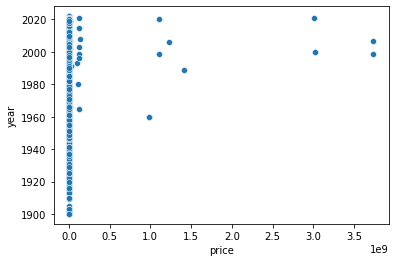

In [6]:
sns.scatterplot(data=cars, x="price", y="year");#visualize outliers

In [7]:
 cars.model.value_counts().value_counts() #determine how many models had low value counts to help avoid overfitting to model

1       15290
2        3887
3        2000
4        1295
5         919
        ...  
171         1
169         1
166         1
159         1
8009        1
Name: model, Length: 438, dtype: int64

In [8]:
cars.price.value_counts()[0]#gets a count of target value = 0 

32895

In [9]:
find_rare=pd.Series([])#create series for rare categorical values
for column in cars.drop(['model','VIN'],axis=1):#loop columns excluding model to populate rare values series
    if cars.dtypes[column]=='object': #checks to make sure column is categorical
        find_rare=pd.concat([find_rare, cars[column].value_counts()])#adds value counts to series
find_rare.sort_values()[:10] #sorts findings and displays 10 most rare categories excluding model

morgan                  3
west virginia (old)     8
fort smith, AR          9
kansas city            11
southwest MS           14
land rover             21
aston-martin           24
meridian               28
southwest TX           30
northeast SD           34
dtype: int64

### Data Preparation

After our initial exploration and fine tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

In [10]:
cars=cars.drop(['VIN', 'id'],axis=1)#drops vin and id

In [11]:
cars=cars.dropna(subset = ['year', 'odometer'])

In [12]:
for column in cars:#loops each column in the dataframe
    if cars.dtypes[column]=='object':#limits loop to categorical features
        counts = cars[column].value_counts()#checks value counts for each column
        cars = cars[~cars[column].isin(counts[counts < 10].index)]#removes rare values to avoid overfit

In [13]:
cars=cars.drop(cars.index[cars['price'] > 60000])# drops price above 6000

In [14]:
cars=cars.drop(cars.index[cars['price'] < 5000])# drops price below 5000

In [15]:
cars=cars.drop(cars.index[cars['year'] < 2000])# drops vehicles older than 2000

In [16]:
cars=cars.drop(cars.index[cars['price'] == 0])# drops records where price is 0

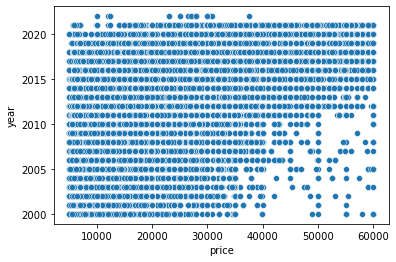

In [17]:
sns.scatterplot(data=cars, x="price", y="year");#check to ensure outliers are trimmed

In [18]:
scaler=StandardScaler()#create scaler for use in modeling

In [19]:
Target_encode=ce.target_encoder.TargetEncoder(return_df=True,)#target encoder 

In [20]:
y=cars['price'] #set target to price before transforming dataset

In [21]:
X=Target_encode.fit_transform(cars.drop(['price'],axis=1),y)#encode categorical features with target encoder

In [22]:
poly=PolynomialFeatures(2).fit(X)#create degree 2 polynomial feature tranformer

In [23]:
X_poly=pd.DataFrame(poly.transform(X),columns=poly.get_feature_names(X.columns)) #create polynomial feature set

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)#separate test and train data

In [25]:
X_poly_train, X_poly_test, y_train, y_test = train_test_split(X_poly, y, random_state = 42)
#separate test and train data for polynomial features

### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

In [26]:
compareModels=pd.DataFrame()#create a dataframe to store modeling test prediction results
compareModels['target']=y_test #assign test target to target column

In [27]:
compareModels['Linear Regression']=LinearRegression().fit(X_train,y_train).predict(X_test)#test linear regression

In [28]:
compareModels['Poly Regression']=LinearRegression().fit(X_poly_train,y_train).predict(X_poly_test)
#test linear regression with polynomial features

In [29]:
compareModels['poly feature select']=RFE(LinearRegression(),n_features_to_select=10).fit(X_poly_train,y_train).predict(X_poly_test)
#test polynomial features with feature selection

In [30]:
estimatorRFE = Lasso(random_state=42, max_iter=10000) #create lasso model with feature selection
alphas = [.1,1, 10,100]
n_features=list(range(1,15))
rfe=RFE(estimatorRFE,)
paramaters= {'rfe_lass__alpha':alphas, 'rfe_trans__n_features_to_select':n_features}
rfe_pipe=Pipeline([('rfe_trans',rfe),('scale',StandardScaler()),('rfe_lass',estimatorRFE)])
Lasso_n_features=GridSearchCV(rfe_pipe,paramaters,scoring='neg_mean_absolute_error',cv=3)

In [31]:
compareModels['lasso_rfe']=Lasso_n_features.fit(X_train,y_train).predict(X_test)# test lasso model

In [32]:
estimatorRFEr = Ridge()# create a ridge model with feature selection
alphas = [.1,1, 10,100]
n_features=list(range(1,15))
rfer=RFE(estimatorRFEr,)
paramaters= {'rfe_ridge__alpha':alphas, 'rfe_trans__n_features_to_select':n_features}
rfer_pipe=Pipeline([('rfe_trans',rfer),('scale',StandardScaler()),('rfe_ridge',estimatorRFEr)])
ridge_n_features=GridSearchCV(rfer_pipe,paramaters,scoring='neg_mean_absolute_error',cv=3)

In [33]:
compareModels['ridge_rfe']=ridge_n_features.fit(X_train,y_train).predict(X_test)

### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight on drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

In [34]:
for column in compareModels:#compare models by mean squared error
    print(column + " mean squared error="+str(mean_squared_error(compareModels[column],compareModels['target'])))

target mean squared error=0.0
Linear Regression mean squared error=33505963.867658876
Poly Regression mean squared error=24995006.698065486
poly feature select mean squared error=34056044.93546155
lasso_rfe mean squared error=33728818.953301296
ridge_rfe mean squared error=33505553.867073614


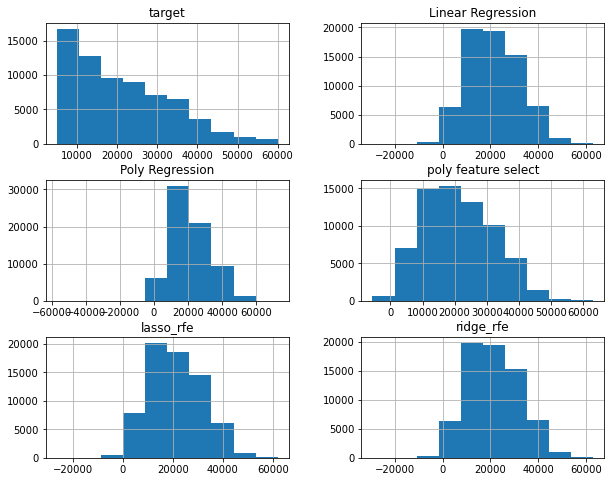

In [35]:
compareModels.hist(figsize=(10,8));#display distribution of each prediction set

    

In [36]:
#combine encoded data with target for correlation
feature_evaluator=Target_encode.fit_transform(cars.drop(['price'],axis=1),y)
feature_evaluator['price']=y

In [37]:
feature_evaluator.corr()['price'].sort_values()# get correlation values for each feature


odometer       -0.317803
title_status    0.106518
state           0.155113
paint_color     0.163702
size            0.210944
condition       0.254444
region          0.256083
fuel            0.311079
drive           0.315366
transmission    0.319686
cylinders       0.320971
manufacturer    0.356887
type            0.392431
year            0.574555
model           0.773565
price           1.000000
Name: price, dtype: float64

### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine tuning their inventory.

Our most successfull model is able to predict the sale price of a car within $5000 on average. While that model uses features which are not intuitive to understanding we can analyse the encoding method we used to generate our model. That analysis shows the features which most closely correlate to sale price. The five most important features in order of importance are model, year, type (i.e. pickup, sedan etc...), manufacturer and number of cylinders. 

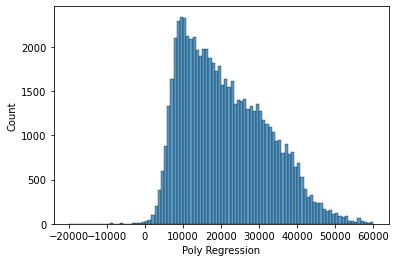

In [38]:
sns.histplot(data=compareModels,binrange=[-20000, 60000], x="Poly Regression");



The plot above shows the price distribution of predicitons made by our model and provides some insight into its use. Note that the model predics very few vlues below $10000 and will even return negative values for price predictions. The model differs from the distribution most for values less than $10000. In addition while preparing the model vehicle years less than 2000 and prices higher than $60000 were omitted to reduce overfitting the outliers.

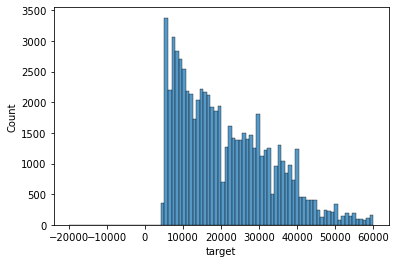

In [39]:
sns.histplot(data=compareModels,binrange=[-20000, 60000], x="target");#this code produces a distribution plot of our target

This model will be most usefull for maintaing inventory of vehicles between $10000 $60000 and bids for inventory must account for the average error of jsut uner $5000.